# Imports

In [1]:
import imp #python module to import other files
%pylab inline
import matplotlib.pyplot as plt #plotting
import math as m
xpy = imp.load_source('xpy', r'/Users/Rui/Dropbox/Research/Stony Brook/Matt Dawber/Python Simulation/x-ray_simulator/xpy/src/xpy.py') #importing my own classes from a file

Populating the interactive namespace from numpy and matplotlib


# Def Data class

In [3]:
def degtoarc (deg):
    """converts degree to arcs
    deg: float
    returns: float
    """
    return deg/180*m.pi

def arctodeg (arc):
    """converts arcs to degree
    arc: float
    returns: float
    """
    return arc*180/m.pi

def qz(theta2,Lambda=1.5406*10**-10): #you can write powers in python as **| 3**2=9
    """calculates qz for a theta-2theta scan
    theta2: float (angle in degree)
    Lambda: float (wavelength in meters)
    """
    return 2*m.pi/Lambda*m.sin(degtoarc(theta2)/2)*2 #q*sin(theta)*2

def l(q,a=3.905*10**-10):
    """calculates h from q and a
    a: float (substrate lattice parameter in meters)
    q: float (momentum transver in meters**-1)
    """
    return q*a/2/m.pi

def load_scans_tupple(path):
    """this function imports data from a simple format(2theta,intensety) from the file in 'path'
    path: string
    """
    data = [] #list to store our data
    data1= [] #list to store our second data
    
    f = open(path, 'r') #opens a file at the beginning
    line=f.readline() #reads the next line of the file (until next \n)
    while (line): #this checks if there is something in line not NON
        words = line.split(',') #split the line into a list of strings for each ','
        if words: #just to be save that you could split the line
            data.append(float(words[0])) #append adds one element to the end of the list
            data1.append(float(words[1])) #append adds one element to the end of the list
        line=f.readline()
    
    return data, data1

class X_Ray_Scan:#everything that belongs to this class needs to be indented
    def __init__(self,path):
        self.import_data(path)
    
    def _calc_qz_(self):
        self.qz = [qz(theta2) for theta2 in self.twotheta]
        
    def _calc_l_(self):
        self.l = [l(qz) for qz in self.qz]
    
    def import_data(self, path):
        """this function imports data from a simple format(2theta,intensety) from the file in 'path'
        path: string
        """
        self.twotheta, self.intensety = load_scans_tupple(path)
        self._calc_qz_()
        self._calc_l_()

# Experiment

In [4]:
path = r'/Users/Rui/Dropbox/Research/STONY BROOK/Matt Dawber/PTO_BTO Project/RAW DATA/XRD/J0608151/J0608151_002_trip_2thetaOmega_speed20.UXD'
data = X_Ray_Scan(path)

wavelength = 1.5418*10**-10 #x-Ray wavelength
background = 1.5 #background counts in your experiment
direct = 6.008759012e-15 #direct beam strength

STOs = xpy.CrystalStructureCheck(path = xpy._SCRIPTPATH_+"Perovskites/STO_b.str")#load the crystal structure
STOs.a = STOs.b = STOs.c = 3.905*10**(-10)#change the lattice parameters if needed
STO = xpy.UnitCell(STOs) #create a unitcell of the crystal structure

#create an experiment object that can do all the needed calculations for you
experiment = xpy.Experiment(STO, STOs, direct = direct, background = background, wavelength = wavelength) 
#sample,base structure(for hkl reference)

substrate = xpy.Film(STO,0,0,0) #creates a bulk crystal of STO

SROs = xpy.CrystalStructureCheck(path = xpy._SCRIPTPATH_+"Perovskites/SRO_b.str")#load the crystal structure
SROc = xpy.UnitCell(SROs)#create a unitcell of the crystal structure
SROs.a = SROs.b = STOs.a

nsro = 36
SROs.c=3.998*10**-10

srofilm = xpy.Film(SROc,0,0,nsro)

PTOs = xpy.CrystalStructureCheck(path = xpy._SCRIPTPATH_+"Perovskites/SRO_b.str")#load the crystal structure
PTOc = xpy.UnitCell(PTOs)#create a unitcell of the crystal structure
PTOs.a = PTOs.b = STOs.a

BTOs = xpy.CrystalStructureCheck(path = xpy._SCRIPTPATH_+"Perovskites/BTO_b.str")#load the crystal structure
BTOc = xpy.UnitCell(BTOs)#create a unitcell of the crystal structure
BTOs.a = BTOs.b = STOs.a

npto = 4
PTOs.c=4.147*10**-10

nbto = 3
BTOs.c=4.147*10**-10

PTOfilm = xpy.Film(PTOc,0,0,npto)
BTOfilm = xpy.Film(BTOc,0,0,nbto)

bilayer = xpy.ThickSample([PTOfilm,BTOfilm])
sl = xpy.Film(bilayer,0,0,21)

experiment.sample = xpy.ThickSample([substrate,srofilm,sl])

e002 = list(experiment.qz_scan(data.qz))
'''e002=list(experiment.l_h_map(l_min = 0.8, l_max = 1.05, l_step = 0.0002,  h_min = -0.07, h_max = 0.07, h_step = 0.0007, k = 0.0, sinomegain = m.sin(20/180*m.pi)))
e001 = []
for x in e002:
    e001.append(list(x))'''

'e002=list(experiment.l_h_map(l_min = 0.8, l_max = 1.05, l_step = 0.0002,  h_min = -0.07, h_max = 0.07, h_step = 0.0007, k = 0.0, sinomegain = m.sin(20/180*m.pi)))\ne001 = []\nfor x in e002:\n    e001.append(list(x))'

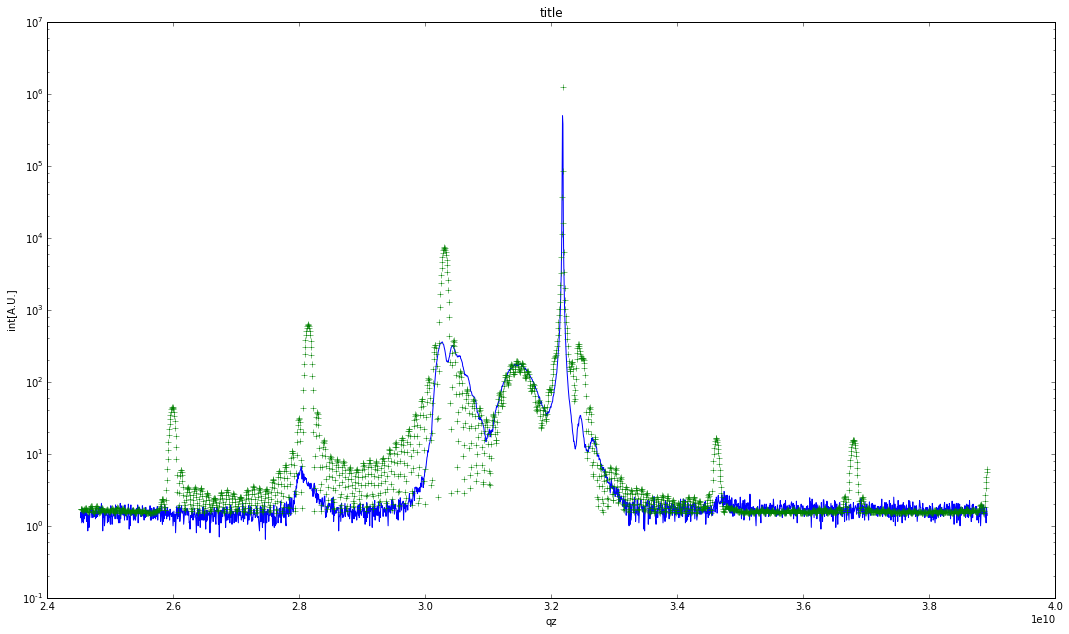

In [5]:
fig = plt.figure(figsize=(14,8), dpi=100) #create a figure
#add an axes to your figure
axes = fig.add_axes([0.0, 0.0, 1.0, 1.0]) # left, bottom, width, height (range 0 to 1)
#plot something in your axes
axes.plot(data.qz, data.intensety) #list of x values, list of y values
axes.plot([x[2] for x in e002], [float(y[3]) for y in e002], color="green", lw=2, ls='*', marker='+')

axes.set_xlabel('qz')
axes.set_ylabel('int[A.U.]')
axes.set_title('title')
axes.set_yscale("log")
#axes.set_xlim(2.8*10**10,3.4*10**10)

In [19]:
len(e002)

200

In [21]:
e001 = []
for x in e002:
    e001.append(list(x))

In [43]:
e001[101]

[[11263072.253586907, 0.0, 12875300596.171844, 2.9202904427174693e+23],
 [11263072.253586907, 0.0, 12878518616.815725, 3.840627087885669e+23],
 [11263072.253586907, 0.0, 12881736637.459608, 4.878559727617076e+23],
 [11263072.253586907, 0.0, 12884954658.103489, 6.029810259204551e+23],
 [11263072.253586907, 0.0, 12888172678.74737, 7.289542678383985e+23],
 [11263072.253586907, 0.0, 12891390699.391253, 8.65238409288479e+23],
 [11263072.253586907, 0.0, 12894608720.035133, 1.0112448380055856e+24],
 [11263072.253586907, 0.0, 12897826740.679016, 1.1663362385703263e+24],
 [11263072.253586907, 0.0, 12901044761.322897, 1.3298294548770196e+24],
 [11263072.253586907, 0.0, 12904262781.96678, 1.5009985824523023e+24],
 [11263072.253586907, 0.0, 12907480802.61066, 1.679078276741843e+24],
 [11263072.253586907, 0.0, 12910698823.254541, 1.863267262408544e+24],
 [11263072.253586907, 0.0, 12913916843.898424, 2.0527320276618022e+24],
 [11263072.253586907, 0.0, 12917134864.542305, 2.2466106867031045e+24],
 [1

In [31]:
e002